In [1]:
import numpy as np
from numpy.random import Generator, PCG64
import math
from heateq import Exact, Simulateur

In [2]:
seed = 213731490053398181466621250222036675538
rng = Generator(PCG64(seed))

In [3]:
# Permet d'obtenir un n-échantillon du vecteur aléatoire d'entrée X
def n_echantillon_X(n):
    return np.vstack(
        (
            rng.uniform(-math.pi, math.pi, (3, n)),
            rng.uniform(0.001, 0.009, (1, n)), 
            rng.uniform(-1., 1., (3, n))
        )
    )

In [4]:
# Simulateurs haute et basse fidélité
f = Simulateur(21, 100)
g = Simulateur(3, 20)

In [5]:
# Espérance exacte de la solution continue
mu_exact = Exact().mu
print(mu_exact)

# Espérance exacte de Y = f(X) (solution discrétisée, haute fidélité)
mu_Y_exact = f.mu
print(mu_Y_exact)

# Espérance exacte de Z = g(X) (solution discrétisée, basse fidélité)
mu_Z_exact = g.mu
print(mu_Z_exact)

41.98447216482205
41.916465294707976
33.03617206344313


# Espérance $\mu_Z$ inconnue

On considère que $\mu_Z$ n'est pas connue.

## Expérience pilote

Estimer $\alpha^*$, $\rho^2$ et $\tau^*$ à l'aide de `ns = 10000` échantillons pilotes, et en déduire une estimation de $\beta=(1+w \tau^*)^2(1-\rho^2)$ (rapport de variance) dans le cas où $\mu_Z$ est inconnue et comparer à $\beta=(1+w)(1-\rho^2)$ dans le cas où $\mu_Z$ est connue (on suppose $w=1/35$).

In [6]:
ns = 10000 # échantillons pilotes
X = n_echantillon_X(ns)

In [26]:
# tf_start = time.process_time() 
Y = f(X)
# tf_stop = time.process_time()
# cf = tf_start - tf_stop

# tg_start = time.process_time() 
Z = g(X)
# tg_stop = time.process_time()
# cg = tg_start - tg_stop

w = 1/35
print("w : ", w)
p_carre = np.cov(Y, Z)[0,1]**2/(np.var(Z)*np.var(Y))
print("p_carre : ", p_carre)
t_star = np.sqrt(p_carre/(w*(1-p_carre)))
print("t_star : ", t_star)
alpha_star = (1-1/t_star)*np.cov(Y, Z)[0,1]/np.var(Z)
print("alpha_star : ", alpha_star)

beta_mu_unknow = ((1+w*t_star)**2)*(1-p_carre)
beta_mu_know = (1+w)*(1-p_carre)
print("beta_mu_unknow : ", beta_mu_unknow)
print("beta_mu_know : ", beta_mu_know)

w :  0.02857142857142857
p_carre :  0.981130688390346
t_star :  42.65985981132006
alpha_star :  0.98169849706706
beta_mu_unknow :  0.09289945630674694
beta_mu_know :  0.01940843479850125


## Estimateur ACV

Utiliser la valeur de $\alpha^*$ estimée précédemment (avec des échantillons pilotes) pour contruire un estimateur par variable de contrôle pour l'espérance de $Y$. 
Faire `nr = 1000` répétitions pour des budgets (en termes de nombre d'évaluations haute fidélité équivalentes) $\tilde{n}_f = c / c_f \in \{5; 10; 20; 50; 100; 200; 500; 1000\}$.

Estimer la réduction de variance à budget équivalent entre l'estimateur par variable de contrôle et l'estimateur Monte Carlo classique (haute fidélité). Est-elle conforme à la valeur de $\beta$ calculée précédemment ?

Tracer l'espérance et l'écart-type (sous forme de barres d'erreur) des estimateurs par variable de contrôle et Monte Carlo (haute fidélité) à budget équivalent en fonction de $\tilde{n}_f$. Sur un autre graphe, tracer l'évolution de la REQM des estimateurs en fonction de $\tilde{n}_f$.

In [28]:
nr = 1000
budgets = [5, 10, 20, 50, 100, 200, 500, 1000]

list_mean_f_bugdet = []
list_mean_y_estim_budget = []
list_var_f_budget = []
list_var_y_estim_budget = []
betas_var = []
betas_formula = []
REQM_estim = []
REQM_hf = []

for n_tilde in budgets:
    print(n_tilde)
    list_mean_f_nr = []
    list_mean_y_estim_nr = []
    list_var_f_nr = []
    list_var_y_estim_nr = []
    betas_formula_nr = []
    
    for i in range(nr):
        X1 = n_echantillon_X(n_tilde)
        Y = f(X1)
        Z1 = g(X1)
        
        n_star = math.floor(n_tilde/(1+t_star*w))
        N_star = math.floor((t_star - 1)*n_star)
        X2 = n_echantillon_X(N_star)
        Z2 = g(X2)
        
        Y_estim = np.mean(Y) - alpha_star*(np.mean(Z1) - np.mean(Z2))
        
        
        list_mean_y_estim_nr.append(Y_estim)
        list_var_y_estim_nr.append(Y_estim)
        betas_formula_nr.append(((1+w*t_star)**2)*(1-p_carre))


        X_f = n_echantillon_X(n_star)
        Y_f = f(X_f)
        list_mean_f_nr.append(np.mean(Y_f))
        list_var_f_nr.append(np.mean(Y_f))

    betas_formula.append(np.mean(betas_formula_nr))
    list_mean_f_bugdet.append(np.mean(list_mean_f_nr))
    list_mean_y_estim_budget.append(np.mean(list_mean_y_estim_nr))
    list_var_f_budget.append(np.var(list_var_f_nr))
    
    REQM_estim.append(np.sqrt((np.mean(list_mean_y_estim_nr) - mu_exact)**2 + np.var(list_mean_y_estim_nr)))
    REQM_hf.append(np.sqrt((np.mean(list_mean_f_nr) - mu_exact)**2 + np.var(list_mean_f_nr)))

    list_var_y_estim_budget.append(np.var(list_var_y_estim_nr))
    betas_var.append(np.var(list_var_y_estim_nr)/np.var(list_var_f_nr))
        

5
10
20
50
100
200
500
1000


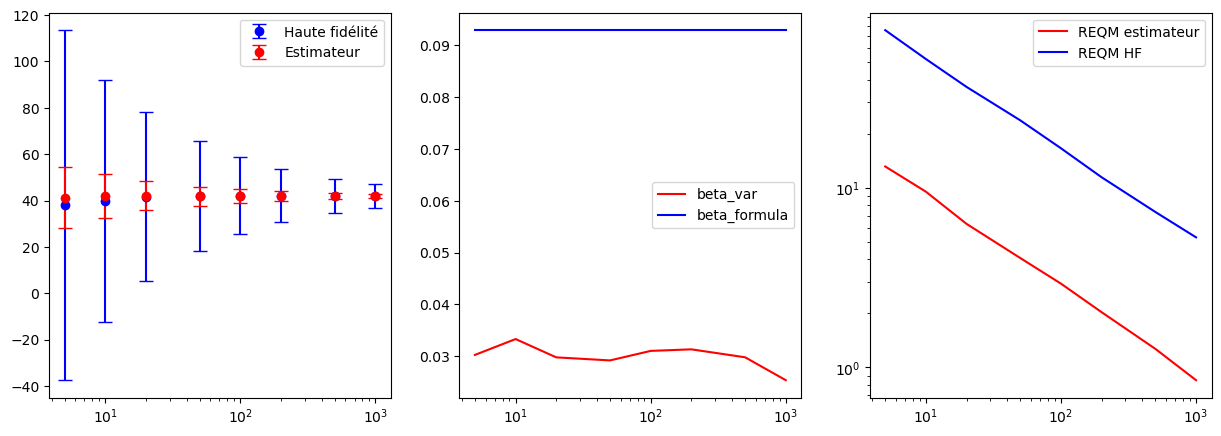

In [30]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].errorbar(budgets, list_mean_f_bugdet, yerr=np.sqrt(list_var_f_budget), fmt='o', color='b', capsize=5, label = 'Haute fidélité')
axs[0].errorbar(budgets, list_mean_y_estim_budget, yerr=np.sqrt(list_var_y_estim_budget), fmt='o', color='r', capsize=5, label = 'Estimateur')
axs[0].set_xscale('log')  # Appliquer l'échelle logarithmique
axs[1].plot(budgets, betas_var, label = 'beta_var', color = 'r')
axs[1].plot(budgets, betas_formula, label = 'beta_formula', color = 'b')
axs[1].set_xscale('log') 
axs[2].plot(budgets, REQM_estim, label = 'REQM estimateur', color = 'r')
axs[2].plot(budgets, REQM_hf, label = 'REQM HF', color = 'b')
axs[2].set_xscale('log')
axs[2].set_yscale('log')

# axs[1].set_yscale('log')  

for ax in axs:
    ax.legend()
plt.show()